In [151]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import ndimage
%matplotlib inline

In [152]:
path = os.path.expanduser('~/Data_607_Final_Project') # Your file must have the same name.
os.chdir(path) # Change this to your working directory
train = pd.read_json('~/DATA602_Final_Project/data/processed/train.json')

In [153]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [154]:
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

## Seperate Ships
This is important for baisic visualization to visually inspect the difference between ships and icebergs. 

In [155]:
icebergs = train[train.is_iceberg==1]
ships = train[train.is_iceberg==0]



# Denoise steps:
1. Use a de-noise algorithm like: http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html
1. Correct for brighter pictures with the mean: http://yeephycho.github.io/2016/08/03/normalizations_in_neural_networks/ It may be useful to use the equalized algorithm.
1. Take the first derivative of each image: https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
1. Look at combing two bands into one image (e.g, just concatinating the strings). Maybe do this step first.
1. Set up data in a way that TF or sklearn can work with.
1. Train/Test split
1. Train Data
1. Cross Validate
1. Run on Kaggle test data

This is what the unedited images look like:

## Concatiante function:
We wanted to concatinate the images so that we could more efficently train on two different feature sets.

Below is an example of what this looks like:

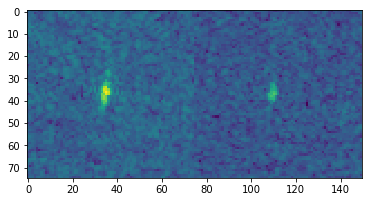

In [156]:
temp = np.concatenate((np.reshape(np.array(train.iloc[0,0]),(75,75)), 
                       np.reshape(np.array(train.iloc[0,1]),(75,75))), axis =1)
#original
imgplot = plt.imshow(temp)

## Denoise: 
This is what it looks like if we use a gaussian filter to denoise the images. Fewer lines, but less distict.
It may be worth looking at different options to denoise. 

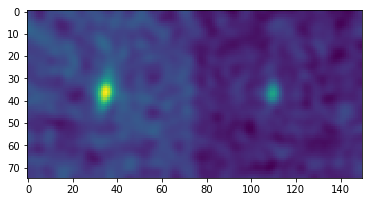

In [157]:
gauss_denoised = ndimage.gaussian_filter(temp, 2)
imgplot = plt.imshow(gauss_denoised)

## Derivatives: 

This is the code to take the first derivative of the image.

More explanation needed [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).

In [158]:
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
from scipy import signal
temp1 = signal.convolve2d(temp,xder,mode='valid')

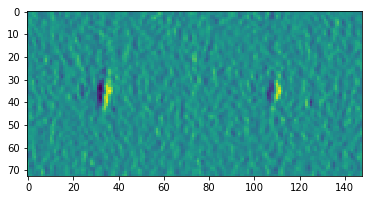

In [159]:
imgplot = plt.imshow(temp1)

Here is the code perform all the pre processing over the data frame.

It saves the results in an np array which is great for other ML libraries.

In [160]:
def pre_process(df):
    """Concatenate, gauss-denoise, first derivative"""
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        # Denoise image
        gauss_denoised = ndimage.gaussian_filter(temp, 2)
        # Take first derivative. 
        deriv = signal.convolve2d(gauss_denoised, xder, mode= 'valid')
        # Append to array
        imgs.append(deriv)

    return np.array(imgs)


Xtrain = pre_process(train) # Training data
Ytrain = np.array(train['is_iceberg']) # Labels. (Data must remain in this order to not misclassify.)

# Processed image:
This image shows the transformation of gausian blur and first derivative.

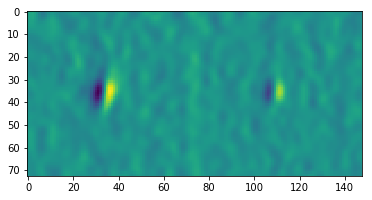

In [161]:
imgplot = plt.imshow(Xtrain[5])

In [162]:
def samplePlots(nparr, title = "Placeholder"):
    fig = plt.figure(1,figsize=(30,15))
    for i in range(9):
        ax = fig.add_subplot(3,3,i+1)
        arr = nparr[i]
        ax.imshow(arr)
        ax.set_title(title)
    plt.show()

# Plain Edge Detection:


In [163]:
def pre_process_edge(df):
    imgs = []
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        sx = ndimage.sobel(concat, axis=0, mode='constant')
        sy = ndimage.sobel(concat, axis=1, mode='constant')
        sob = np.hypot(sx, sy)
        imgs.append(sob)
    return imgs

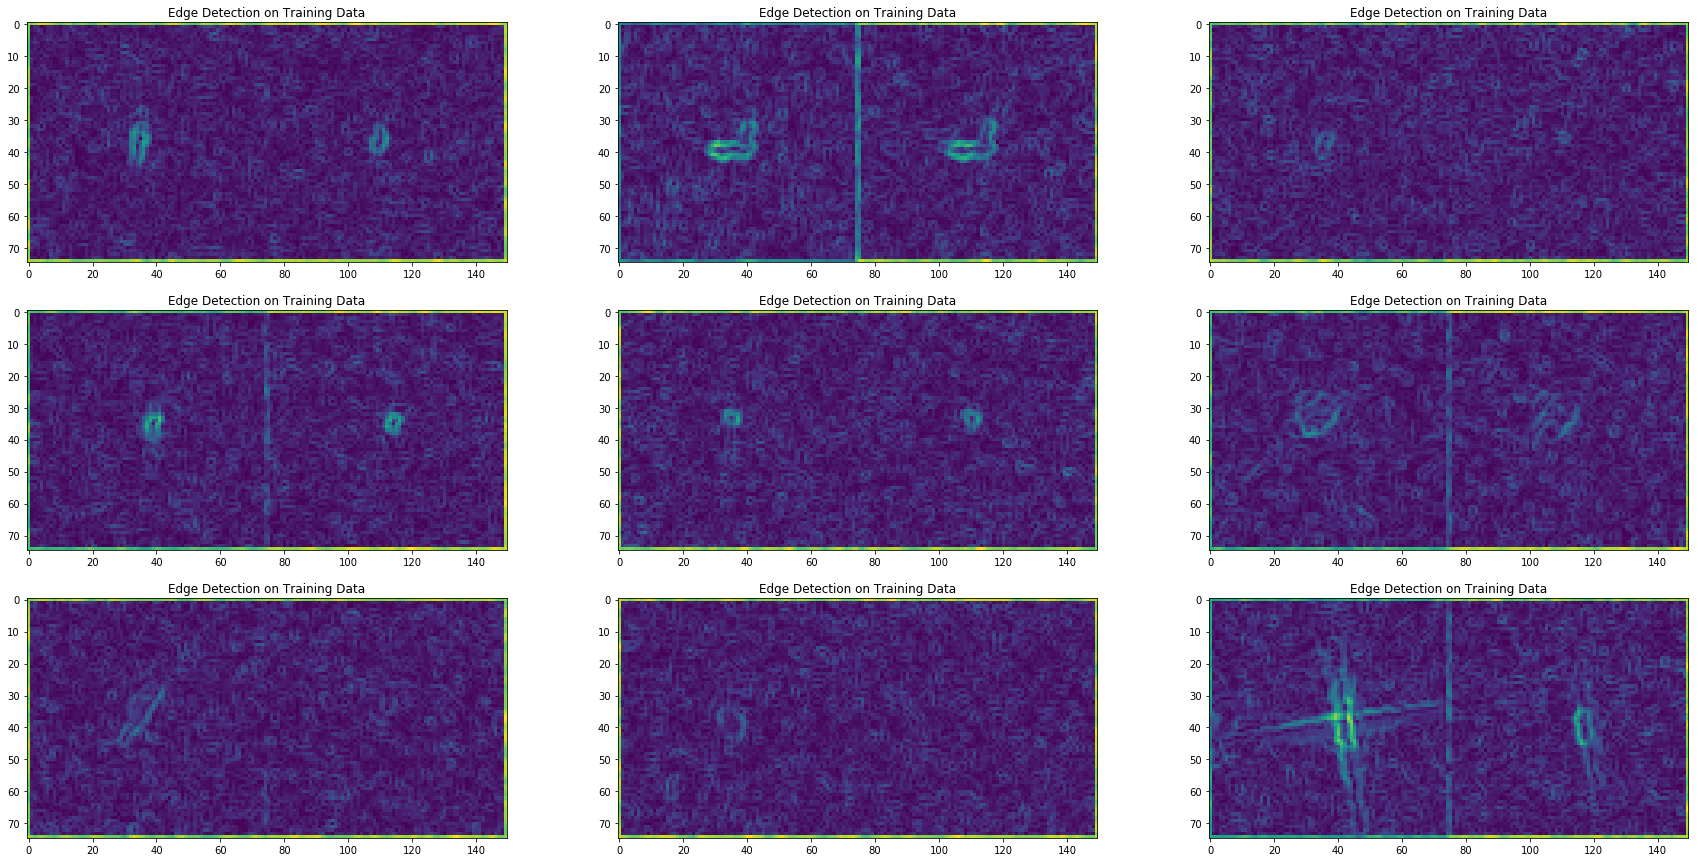

In [164]:
samplePlots(pre_process_edge(train), 'Edge Detection on Training Data')

We can see that This works well for some, but not others. 

In [165]:
arr = Xtrain[3] #np.reshape(np.array(icebergs.iloc[2,0]),(75,75))
sx = ndimage.sobel(arr, axis=0, mode='constant')
sy = ndimage.sobel(arr, axis=1, mode='constant')
sob = np.hypot(sx, sy)

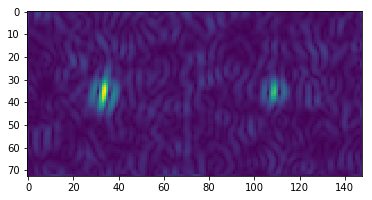

In [166]:
implot = plt.imshow(sob)

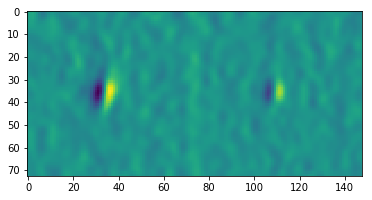

In [167]:
implot = plt.imshow(Xtrain[3])

In [168]:
def pre_process_deriv(df):
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        # Denoise image
        #gauss_denoised = ndimage.gaussian_filter(temp, 2)
        # Take first derivative. 
        deriv = signal.convolve2d(concat, xder, mode= 'valid')
        # Append to array
        imgs.append(deriv)

    return np.array(imgs)



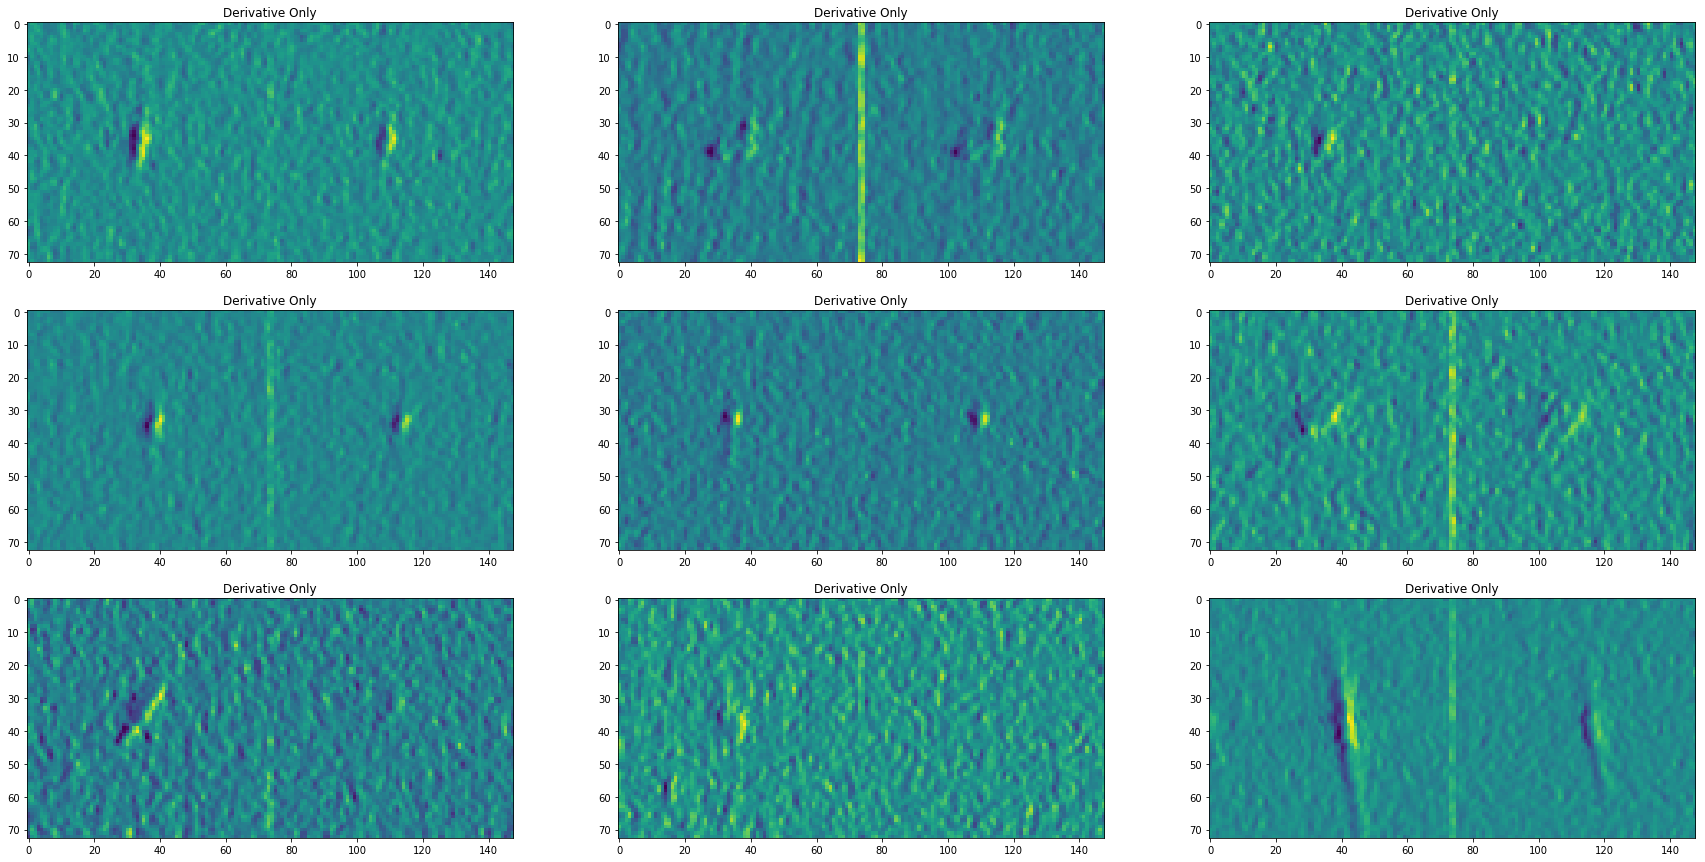

In [169]:
samplePlots(pre_process_deriv(train), "Derivative Only")

Un-processed images of icebergs:

In [170]:
def reshapedDF(df):
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        
        # Append to array
        imgs.append(concat)

    return np.array(imgs)

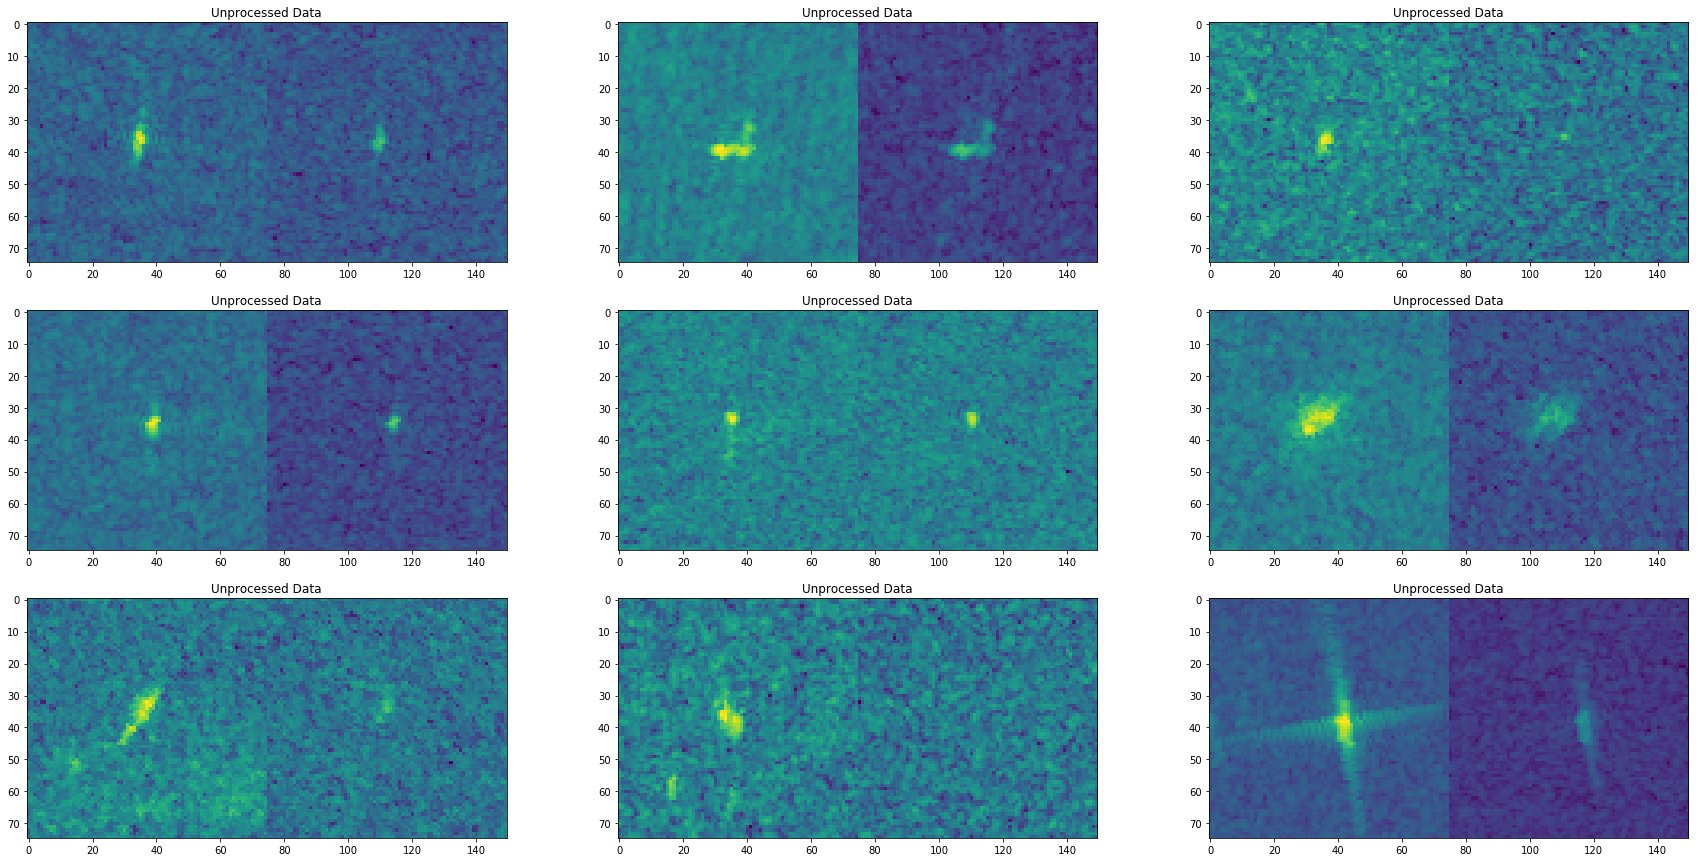

In [171]:
samplePlots(reshapedDF(train), 'Unprocessed Data')

In [172]:
def pre_process_edge_et_all(df):
    imgs = []
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        # Denoise image
        gauss_denoised = ndimage.gaussian_filter(temp, 2)
        # Take first derivative. 
        deriv = signal.convolve2d(gauss_denoised, xder, mode= 'valid')
        sx = ndimage.sobel(deriv, axis=0, mode='constant')
        sy = ndimage.sobel(deriv, axis=1, mode='constant')
        sob = np.hypot(sx, sy)
        imgs.append(sob)
    return imgs

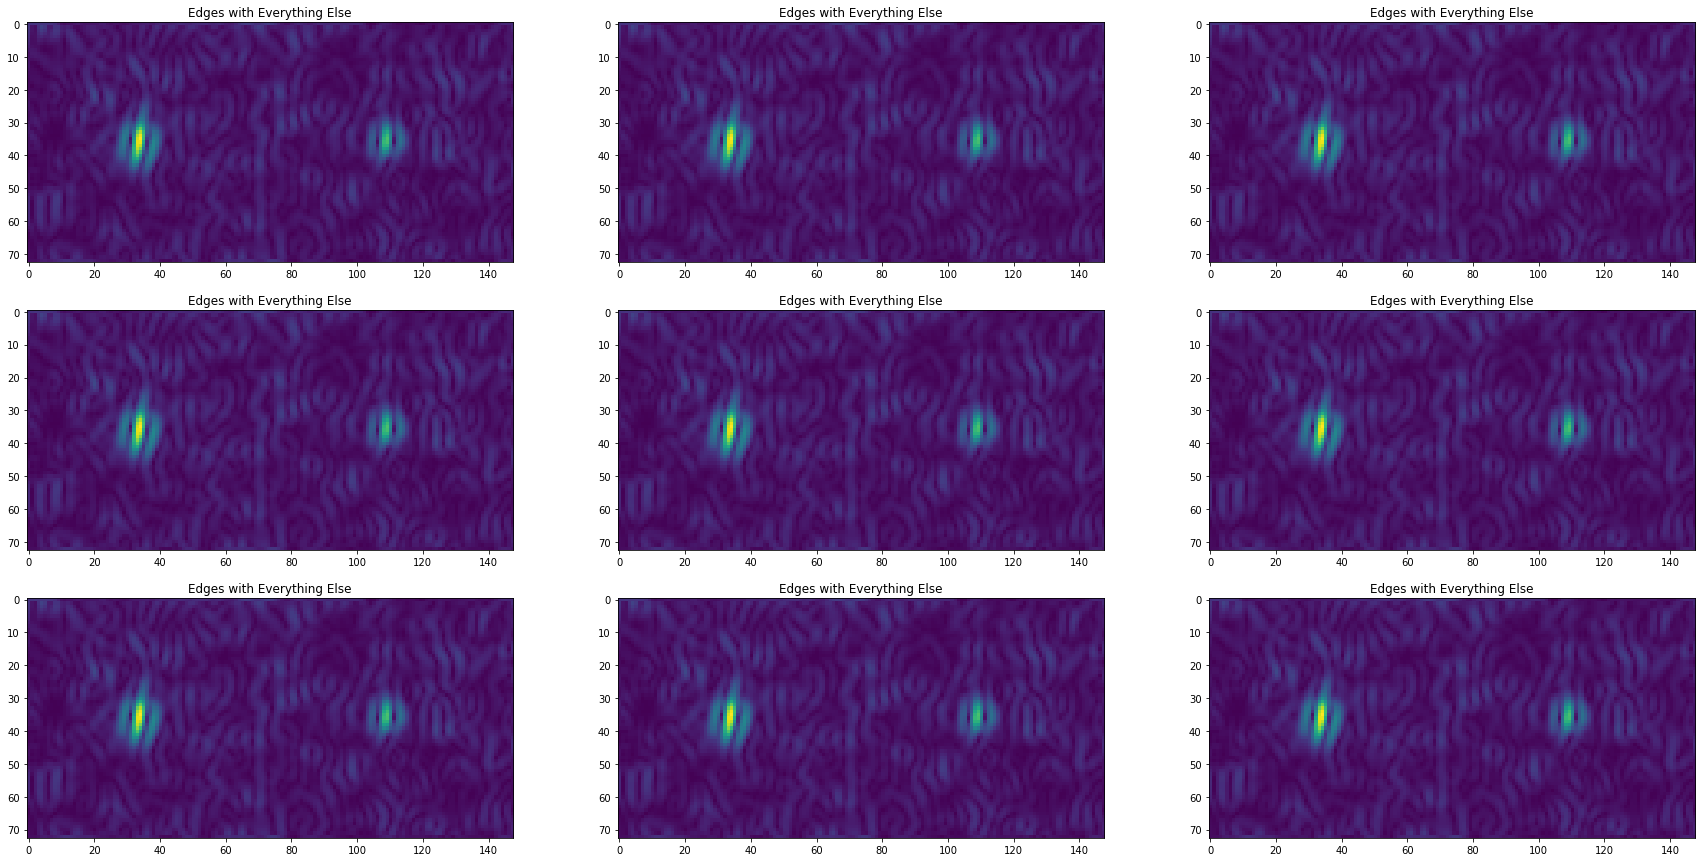

In [173]:
samplePlots(pre_process_edge_et_all(train), "Edges with Everything Else")

In [174]:
def pre_process_abs(df):
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        # Denoise image
        #gauss_denoised = ndimage.gaussian_filter(temp, 2)
        # Take first derivative. 
        deriv = signal.convolve2d(concat, xder, mode= 'valid')
        # Append to array
        deriv = np.absolute(deriv)
        imgs.append(deriv)

    return np.array(imgs)

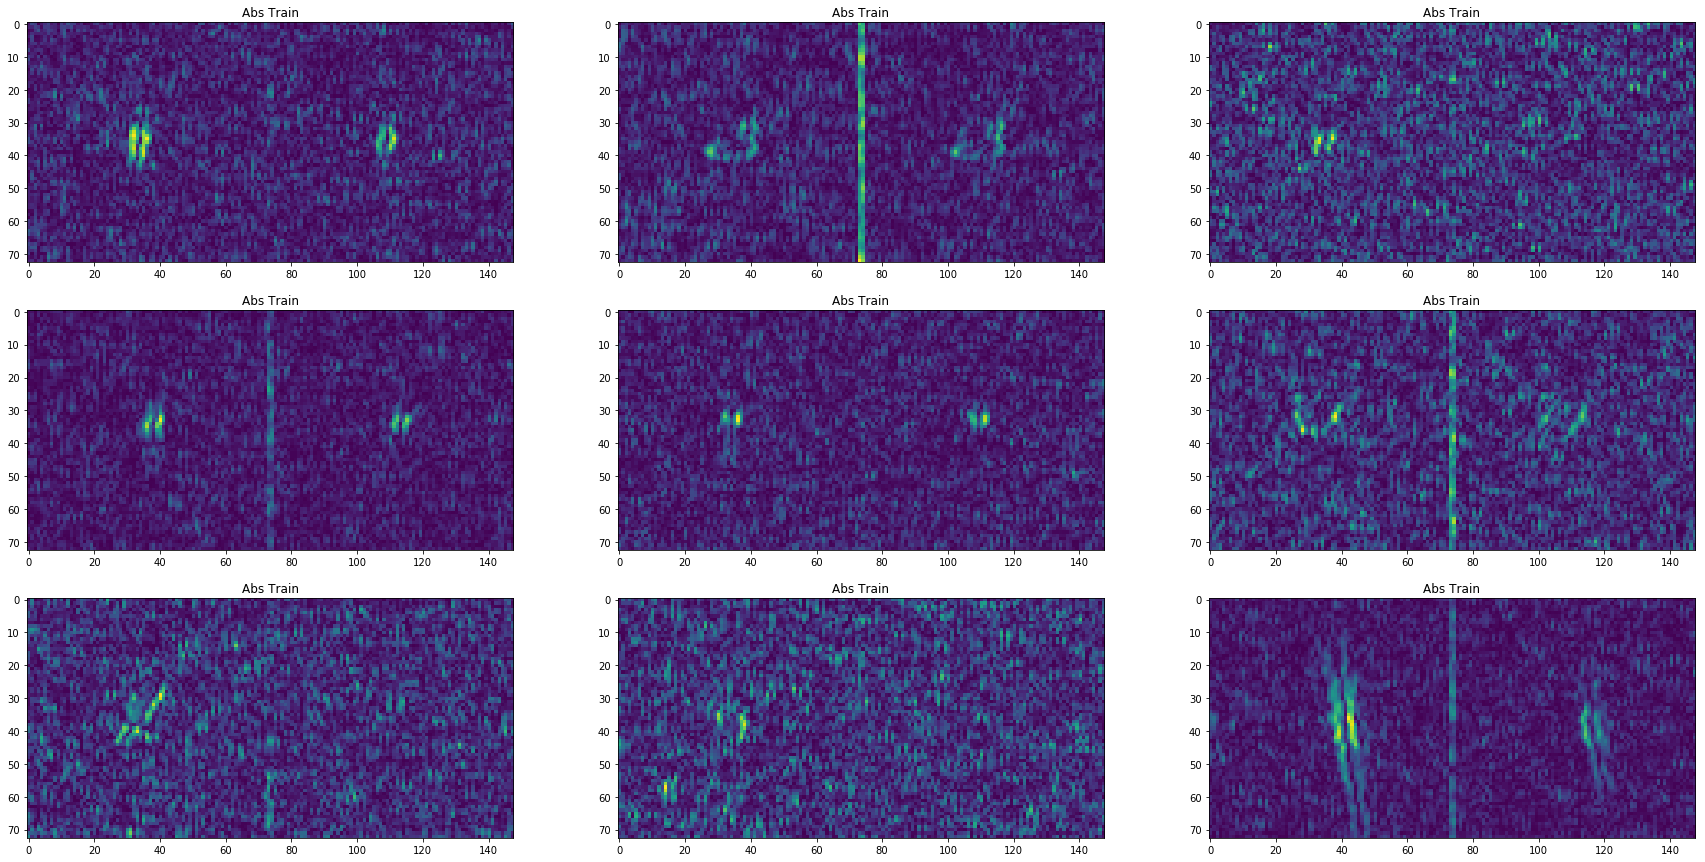

In [175]:
samplePlots(pre_process_abs(train), 'Abs Train')

In [192]:
def pre_process_median(df):
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        # Denoise image
        mean_denoised = ndimage. median_filter(concat, 5) # Five can be changed but it's a nice multiple of 75
        # Take first derivative. 
        deriv = signal.convolve2d(mean_denoised, xder, mode= 'valid')
        # Append to array
        deriv = np.absolute(deriv)
        sx = ndimage.sobel(deriv, axis=0, mode='constant')
        sy = ndimage.sobel(deriv, axis=1, mode='constant')
        sob = np.hypot(sx, sy)
        imgs.append(sob)
        #imgs.append(deriv)

    return np.array(imgs)

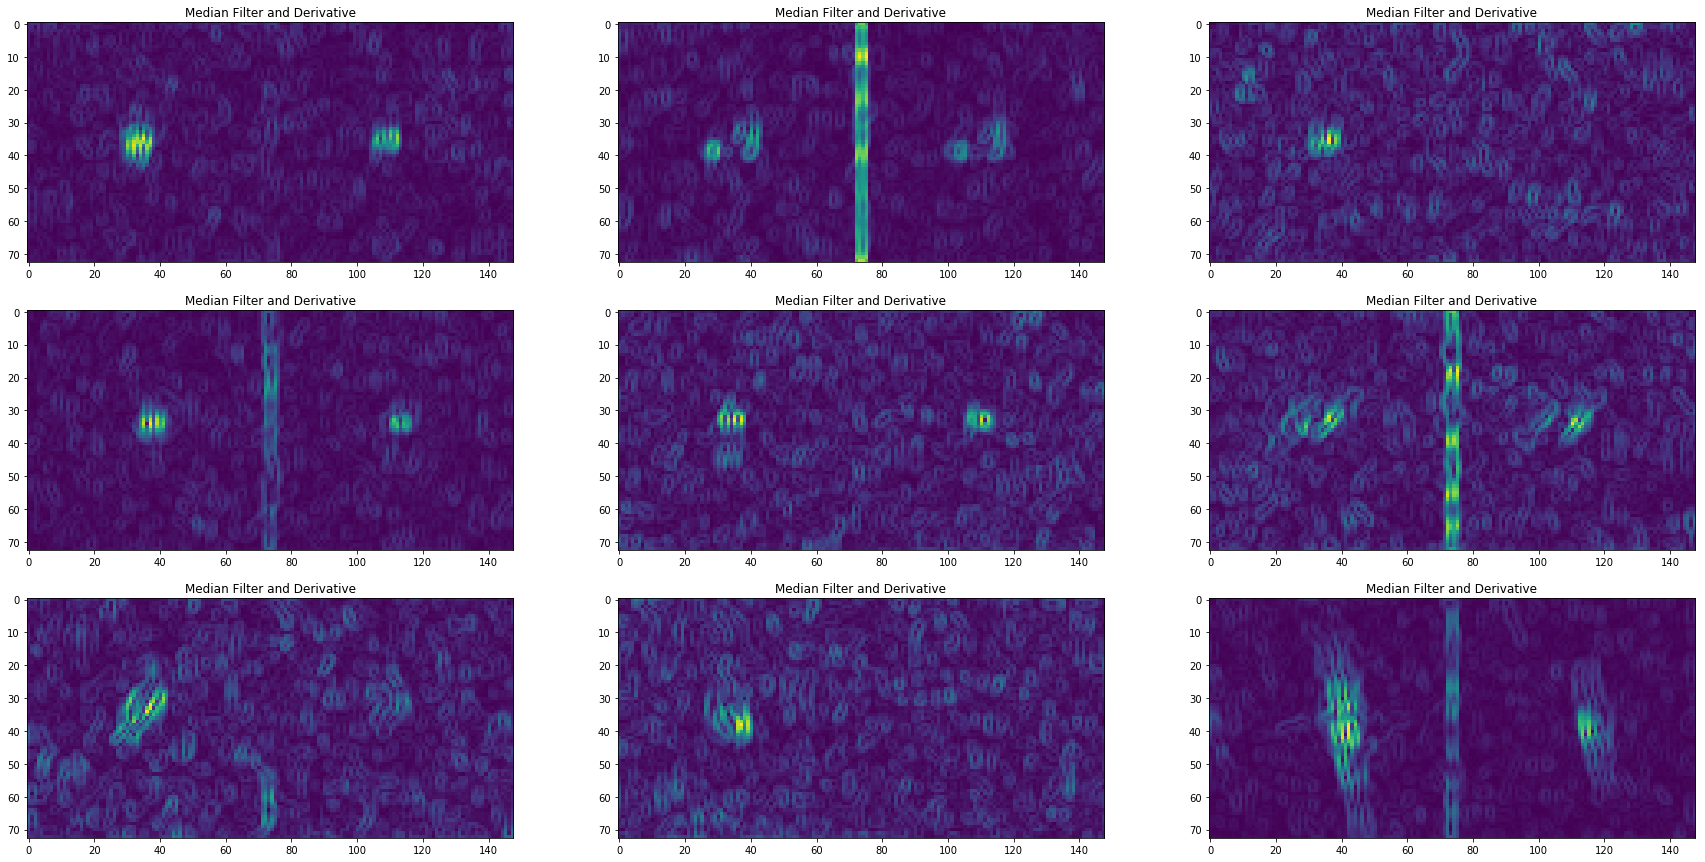

In [193]:
samplePlots(pre_process_median(train), 'Median Filter and Derivative')

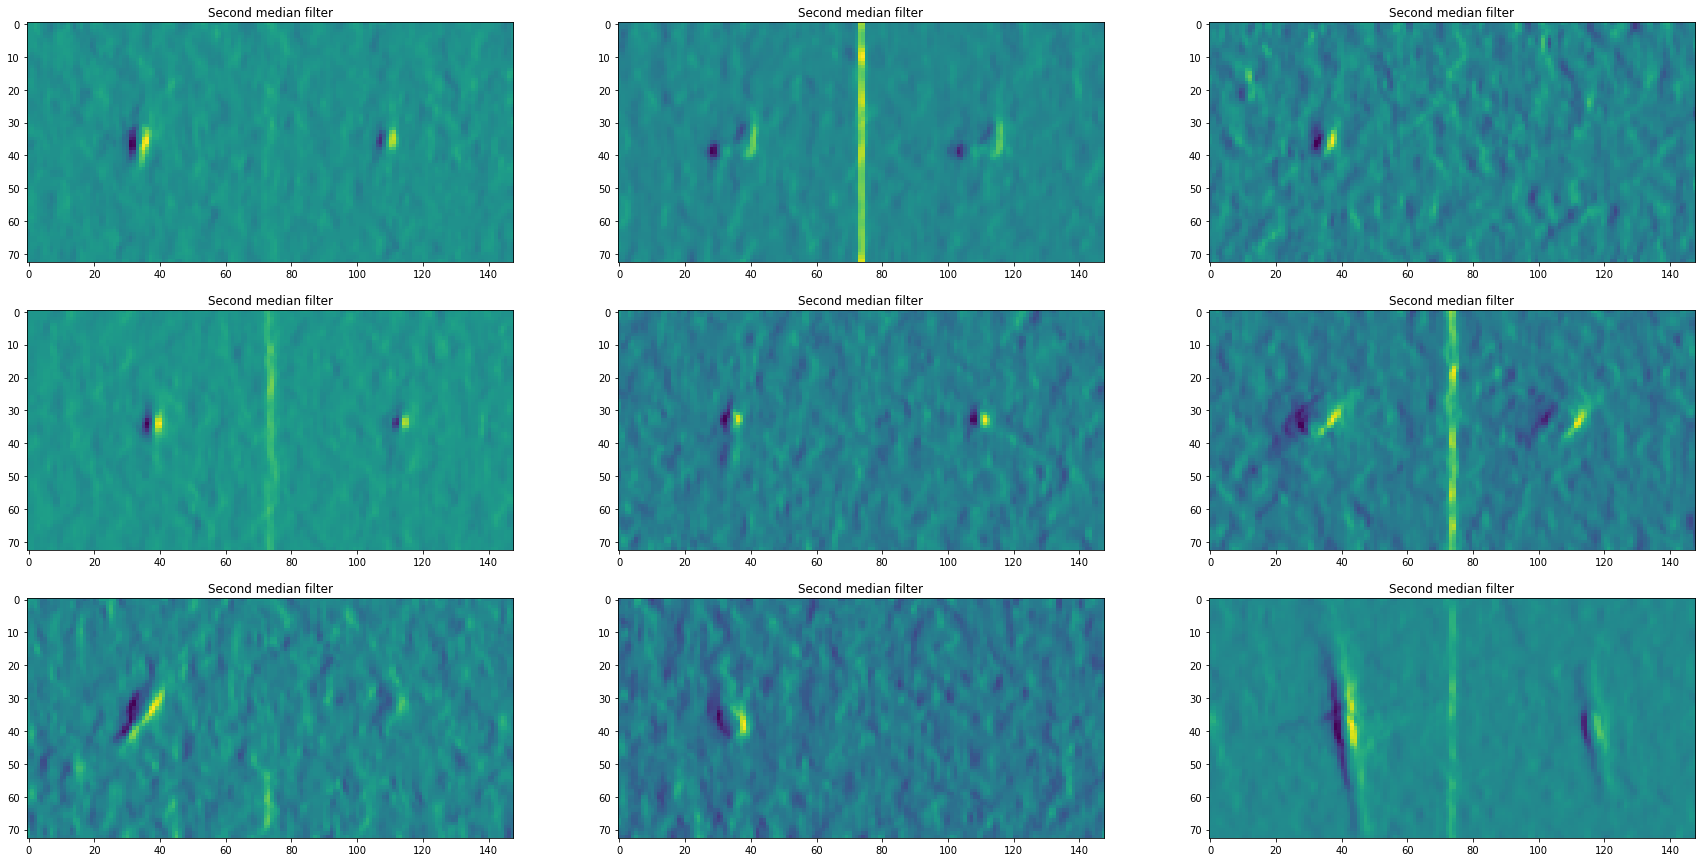

In [180]:
samplePlots(pre_process_median(train), 'Second median filter')

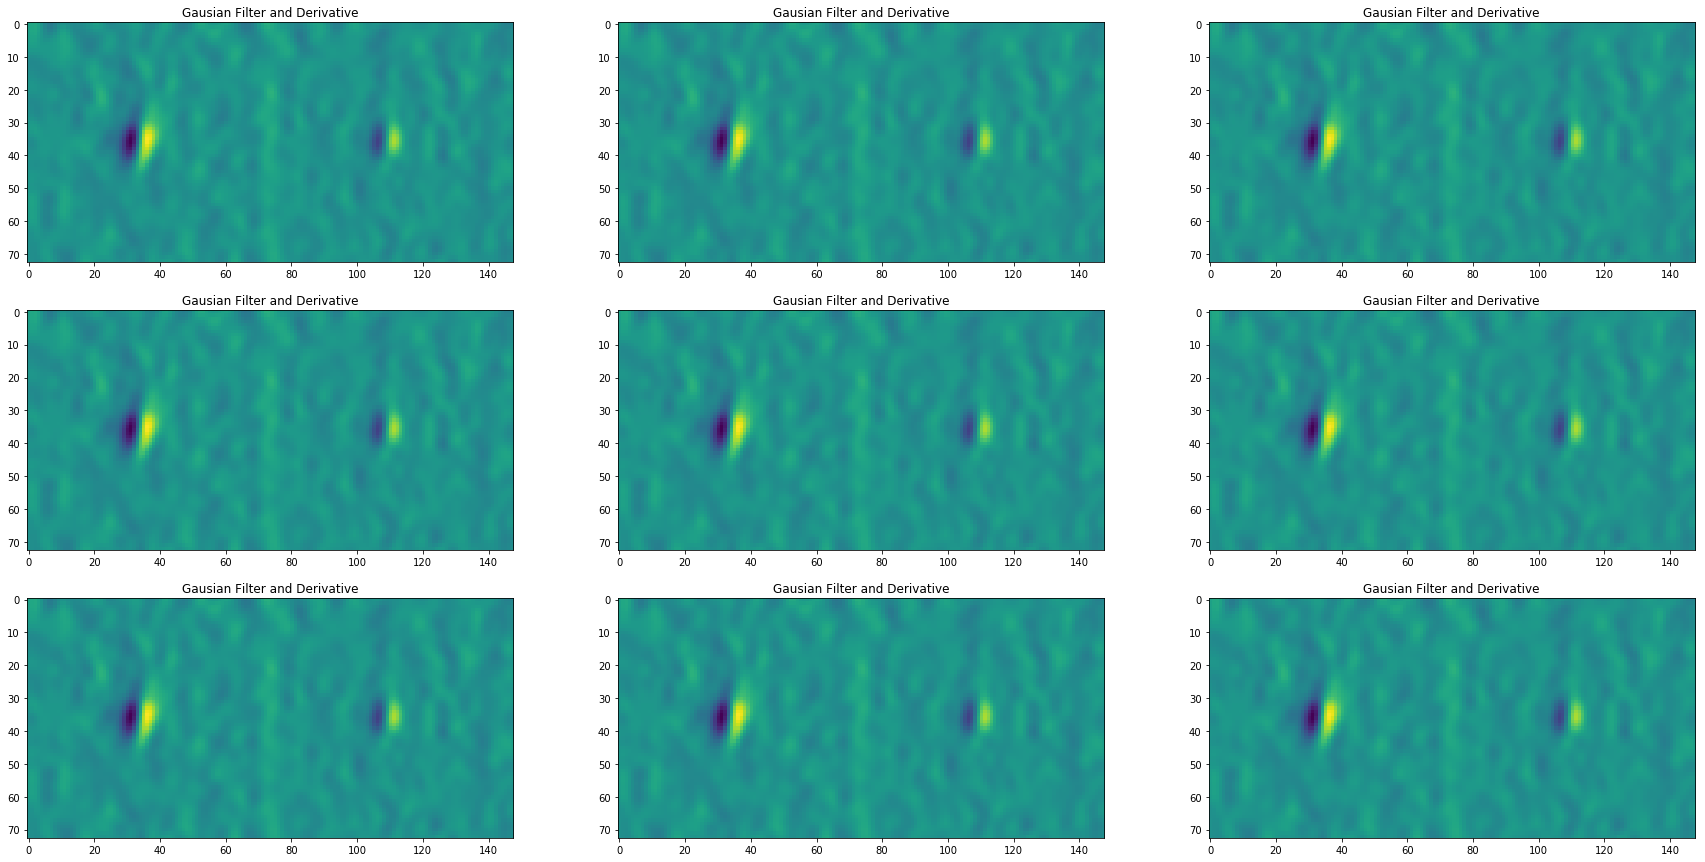

In [178]:
samplePlots(pre_process(train), 'Gausian Filter and Derivative')